In [26]:
import pandas as pd
from scipy.stats import pearsonr
import math
import matplotlib.pyplot as plt

In [27]:
import pandas as pd
import math
from scipy.stats import pearsonr

def read_and_preprocess(file_path):

    predicted_df = pd.read_csv(file_path)

    true_df = pd.read_csv("curated_dataset/conservation_scores.csv")

    # Convertir 'conservation score' en chaîne avant de fusionner
    df = pd.DataFrame(true_df)
    df['conservation score'] = df['conservation score'].astype(str)

    # Grouper et concaténer les valeurs de 'conservation score'
    true_df = df.groupby('sequence id')['conservation score'].agg(' '.join).reset_index()

    # Extraire la partie commune des séquences
    predicted_df['sequence_id'] = predicted_df['header'].str.extract(r'([A-Za-z0-9]+\.[0-9]+/[0-9]+-[0-9]+)')
    true_df['sequence_id'] = true_df['sequence id'].str.extract(r'([A-Za-z0-9]+\.[0-9]+/[0-9]+-[0-9]+)')

    return predicted_df, true_df

def merge_dataframes(predicted_df, true_df):
    # Fusionner les DataFrames par la colonne 'sequence_id'
    combined_df = pd.merge(predicted_df, true_df, how='inner',
                           left_on='sequence_id', right_on='sequence_id')
    return combined_df

def validate_data(combined_df):
    # Convertir les valeurs de 'conservation' et 'conservation score' en listes de nombres
    combined_df['conservation'] = combined_df['conservation'].apply(lambda x: [float(val) for val in x.split()])
    combined_df['conservation score'] = combined_df['conservation score'].apply(lambda x: [float(val) for val in x.split()])

    # Supprimer les lignes contenant des infinis ou des NaNs
    combined_df = combined_df[~combined_df['conservation'].apply(lambda x: any(math.isinf(val) or math.isnan(val) for val in x))]
    combined_df = combined_df[~combined_df['conservation score'].apply(lambda x: any(math.isinf(val) or math.isnan(val) for val in x))]

    return combined_df

def calculate_pearson_numpy(combined_df):
    # Calculer le coefficient de Pearson par résidu
    pearson_coefficient, _ = pearsonr(
        combined_df['conservation'].explode(), combined_df['conservation score'].explode())
    return pearson_coefficient

def calculate_pearson(combined_df):
    # Calculer le coefficient de Pearson manuellement
    x = combined_df['conservation'].explode()
    y = combined_df['conservation score'].explode()

    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_xy = sum(x_i * y_i for x_i, y_i in zip(x, y))
    sum_x_squared = sum(x_i**2 for x_i in x)
    sum_y_squared = sum(y_i**2 for y_i in y)

    pearson_numerator = n * sum_xy - sum_x * sum_y
    pearson_denominator = math.sqrt((n * sum_x_squared - sum_x**2) * (n * sum_y_squared - sum_y**2))
    pearson_coefficient = pearson_numerator / pearson_denominator

    return pearson_coefficient

def calculate_pearson_from_file(file_name):
    predicted_df, true_df = read_and_preprocess(file_name)
    combined_df = merge_dataframes(predicted_df, true_df)
    validated_df = validate_data(combined_df)
    pearson_coefficient = calculate_pearson(validated_df)
    return pearson_coefficient


In [35]:
pearson_coefficients = []
for file_name in ["output_results_curated_8M.csv", "output_results_curated_35M.csv", "output_results_curated_esm2_t30_150M_UR50D.csv"]:
    pearson_coefficient = calculate_pearson_from_file(file_name)
    print(pearson_coefficient)
    pearson_coefficients.append(pearson_coefficient)
print(pearson_coefficients)

0.38287660054531003
0.4731049272176228
0.5776415220274975
[0.38287660054531003, 0.4731049272176228, 0.5776415220274975]


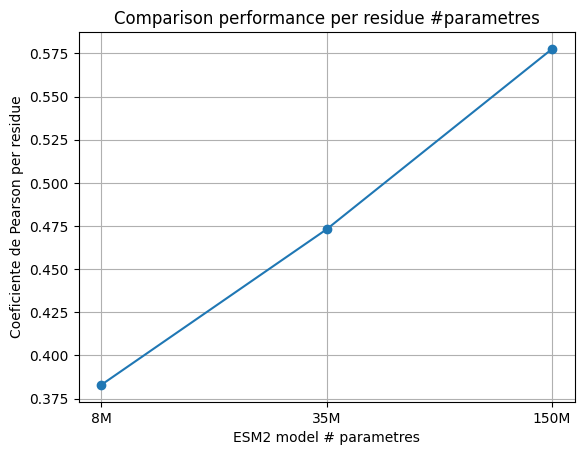

In [40]:
plt.plot(['8M', '35M', '150M'], pearson_coefficients, marker='o')
plt.xlabel('ESM2 model # parametres')
plt.ylabel('Coeficiente de Pearson per residue')
plt.title('Comparison performance per residue #parametres')
plt.grid(True)
plt.show()

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def calculate_pearson_by_sequence(predicted_file, true_file):
    # Lire les données
    predicted_df = pd.read_csv(predicted_file)
    true_df = pd.read_csv(true_file)
    
    # Extraire les séquences
    predicted_df['sequence_id'] = predicted_df['header'].str.extract(r'([A-Za-z0-9]+\.[0-9]+/[0-9]+-[0-9]+)')
    true_df['sequence_id'] = true_df['sequence id'].str.extract(r'([A-Za-z0-9]+\.[0-9]+/[0-9]+-[0-9]+)')
    print(true_df)
    
    # Fusionner par séquence
    combined_df = pd.merge(predicted_df, true_df, how='inner', left_on='sequence_id', right_on='sequence_id')

    # Calculer le coefficient de Pearson par séquence
    pearson_coefficient, _ = pearsonr(combined_df['conservation'], combined_df['conservation score'])

    return pearson_coefficient

# Exemple d'utilisation
file1 = "output_results_curated_8M.csv"
file2 = "output_results_curated_35M.csv"
true_file = "curated_dataset/conservation_scores.csv"

pearson_coefficient1 = calculate_pearson_by_sequence(file1, true_file)
pearson_coefficient2 = calculate_pearson_by_sequence(file2, true_file)

# Afficher dans un graphique en lignes
files = ['File 1', 'File 2']
coefficients = [pearson_coefficient1, pearson_coefficient2]

plt.plot(files, coefficients, marker='o')
plt.xlabel('Fichiers')
plt.ylabel('Coefficient de Pearson par séquence')
plt.title('Coefficients de Pearson par séquence pour différents fichiers')
plt.show()


                  sequence id  residue number  conservation score  \
0        A0A1Y2ANA8.1/421-668               1            0.105774   
1        A0A1Y2ANA8.1/421-668               2            0.202515   
2        A0A1Y2ANA8.1/421-668               3            0.141357   
3        A0A1Y2ANA8.1/421-668               4            0.144287   
4        A0A1Y2ANA8.1/421-668               5            0.139038   
...                       ...             ...                 ...   
5827315    A0A5J5ICB5.1/11-99              85            0.531250   
5827316    A0A5J5ICB5.1/11-99              86            0.302979   
5827317    A0A5J5ICB5.1/11-99              87            0.243530   
5827318    A0A5J5ICB5.1/11-99              88            0.148193   
5827319    A0A5J5ICB5.1/11-99              89            0.145996   

                  sequence_id  
0        A0A1Y2ANA8.1/421-668  
1        A0A1Y2ANA8.1/421-668  
2        A0A1Y2ANA8.1/421-668  
3        A0A1Y2ANA8.1/421-668  
4        A0

TypeError: unsupported operand type(s) for +: 'float' and 'str'